<a href="https://colab.research.google.com/github/FUHannes/Deep-Learning/blob/main/Ex04/Exercise4_Vlad_improved_Hannes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [13]:
import time
# for plotting
import matplotlib.pyplot as plt

# numpy is the standard numerical library for Python
import numpy as np

# torch is the deep learning library we are using in this course
import torch

from torch import nn, tensor

In [14]:
from torch.utils.data import DataLoader, Dataset
class CIFARDataset(Dataset):
    def __init__(self, x_train, y_train):
        self.x_train = torch.from_numpy(x_train).moveaxis(3, 1)
        self.y_train = torch.from_numpy(y_train).type(torch.LongTensor)

    def __len__(self):
        return len(self.x_train)

    def __getitem__(self, idx):
        return self.x_train[idx], self.y_train[idx]

(3000, 32, 32, 3) float32
(3000,) float64
(300, 32, 32, 3) float32


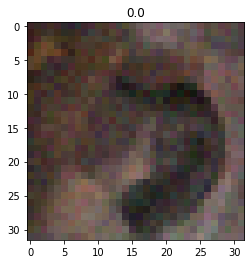

Data shapes:
torch.Size([64, 3, 32, 32]) torch.Size([64])


In [26]:
fh = np.load('prediction-challenge-02-data-2.npz')
x_train = fh['x_train']
y_train = fh['y_train']
x_test = fh['x_test']

print(x_train.shape, x_train.dtype)
print(y_train.shape, y_train.dtype)

print(x_test.shape, x_test.dtype)

plt.imshow(x_train[0])
plt.title(y_train[0])
plt.show()

training_data = CIFARDataset(x_train, y_train)
train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)

train_features, train_labels = next(iter(train_dataloader))

print("Data shapes:")
print(train_features.shape, train_labels.shape)

In [51]:
input_channels = 3
hidden_sizes = [128, 64, 32, 32]
output_size = 3

hidden_layers = []
for size_1, size_2 in zip(hidden_sizes, hidden_sizes[1:]):
    hidden_layers.append(nn.Linear(size_1, size_2))
    hidden_layers.append(nn.ReLU())

model = nn.Sequential(
          # 1st conv layer
          nn.Conv2d(input_channels, 6, kernel_size=3),
          nn.ReLU(),
          nn.MaxPool2d(kernel_size=2, stride=2),
    
          # 2st conv layer
          nn.Conv2d(6, 16, kernel_size=3),
          nn.ReLU(),
          nn.MaxPool2d(kernel_size=2, stride=2),
    
          # deep neural network
          nn.Flatten(1),
          nn.Linear(16 *6*6, hidden_sizes[0]),
          nn.ReLU(),
          *hidden_layers,
          nn.Dropout(),
          nn.Linear(hidden_sizes[-1], output_size),
)
print(model)

Sequential(
  (0): Conv2d(3, 6, kernel_size=(3, 3), stride=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Flatten(start_dim=1, end_dim=-1)
  (7): Linear(in_features=576, out_features=128, bias=True)
  (8): ReLU()
  (9): Linear(in_features=128, out_features=64, bias=True)
  (10): ReLU()
  (11): Linear(in_features=64, out_features=32, bias=True)
  (12): ReLU()
  (13): Linear(in_features=32, out_features=32, bias=True)
  (14): ReLU()
  (15): Dropout(p=0.5, inplace=False)
  (16): Linear(in_features=32, out_features=3, bias=True)
)


In [62]:
labels = {0.0:'cat', 1.0:'dog', 2.0:'frog'}

In [53]:
a = model(train_features)
a.shape

torch.Size([64, 3])

In [54]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.003, momentum=0.9)
time0 = time.time()
epochs = 200
     
for e in range(epochs):
    running_loss = 0
    
    for i, (x, y) in enumerate(train_dataloader):
        # Training pass
        optimizer.zero_grad()

        y_pred = model(x)
        loss = loss_fn(y_pred, y)

        #This is where the model learns by backpropagating
        loss.backward()

        #And optimizes its weights here
        optimizer.step()

        running_loss += loss.item()
    print(f"Epoch {e} - Training loss: {running_loss/len(x[0])}", end="\r")


print("\nTraining Time (in minutes) =",(time.time()-time0)/60) 


Epoch 199 - Training loss: 0.6281312654415766
Training Time (in minutes) = 2.3258826812108357


In [55]:
size = len(train_dataloader.dataset)
test_loss, correct = 0, 0

with torch.no_grad():
    for i in range(size):
        x = train_dataloader.dataset.x_train[i].unsqueeze(0)
        y = train_dataloader.dataset.y_train[i].unsqueeze(0)
        pred = model(x)
        test_loss += loss_fn(pred, y).item()
        correct += (pred.argmax(1) == y).type(torch.float).sum().item()

        print(f"{i}  Accuracy: {(100*correct/size):>0.1f}%, Avg loss: {test_loss/size:>8f}", end="\r")

In [56]:
test_data = torch.from_numpy(x_test).moveaxis(3, 1)
prediction = np.ndarray(len(test_data))
with torch.no_grad():
    for i, x in enumerate(test_data):
        y_pred = model(x.unsqueeze(0))
        prediction[i] = y_pred.argmax(1).item()

In [65]:
from random import randint

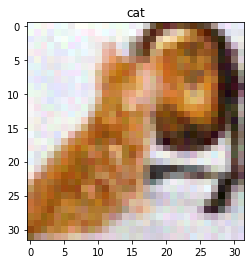

In [73]:
i = randint(0,300)


plt.imshow(x_test[i])
plt.title(labels[prediction[i]])
plt.show()

# 